In [5]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [6]:
env = BlackjackEnv()

In [24]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float) # across episodes
    
    # The final value function
    V = defaultdict(float)
    
    # Implement this!
    for i_e in range(1, num_episodes+1):
        # Print out which episode we're on, useful for debugging.
        if i_e % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_e, num_episodes), end="")
            sys.stdout.flush()
            
        episode = [] # episode: array of (state, action, reward) tuples
        # state: sum_hand(self.player), self.dealer[0], usable_ace(self.player)
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            # collect info of this episode
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # get list of unique states experienced in this episode
        states = set(e[0] for e in episode)
        for state in states: # for each state
            returns_count[state] +=1.0 # add counter of the state for first time occurrence
            
            # find index of first time occurrence of the state in episode
            first_idx = 0
            for i, e in enumerate(episode):
                if e[0] == state:
                    first_idx = i
                    break
            
            # get gain of the state in this episode
            gain = 0
            for i, e in enumerate(episode[first_idx:]): 
                gain += (discount_factor ** i) * e[2]
                
            returns_sum[state] += gain # accumulate return of the state accross episode
            
            V[state] = returns_sum[state]/returns_count[state]
    return V    

In [25]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 10000/10000.

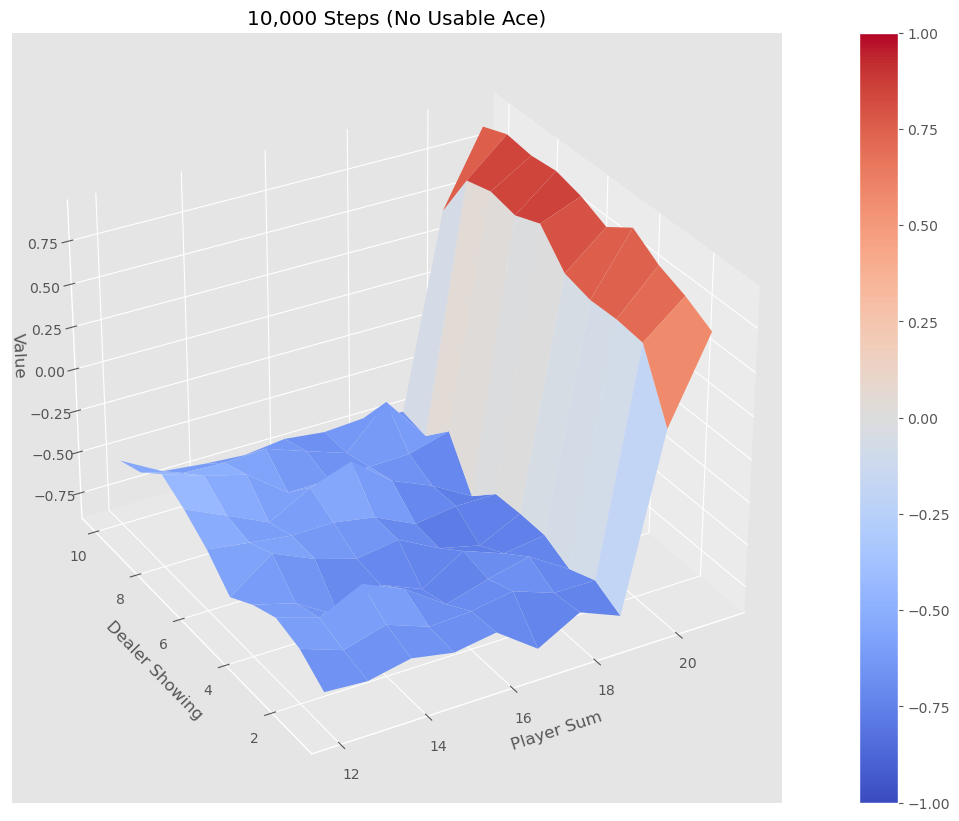

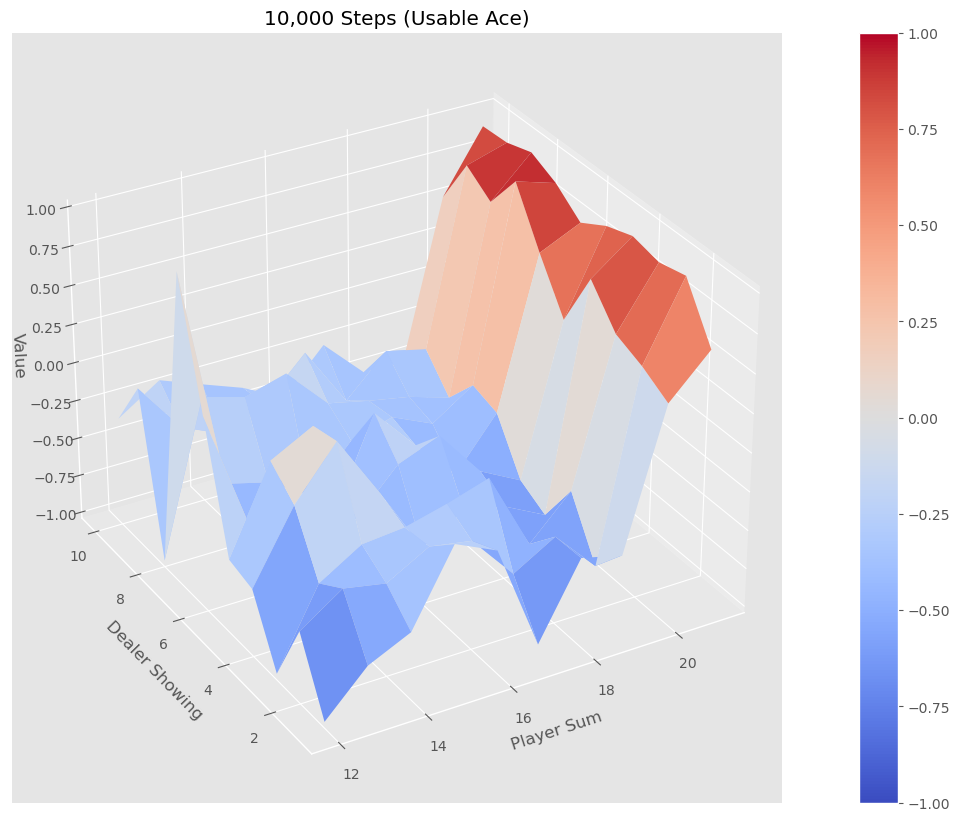

Episode 500000/500000.

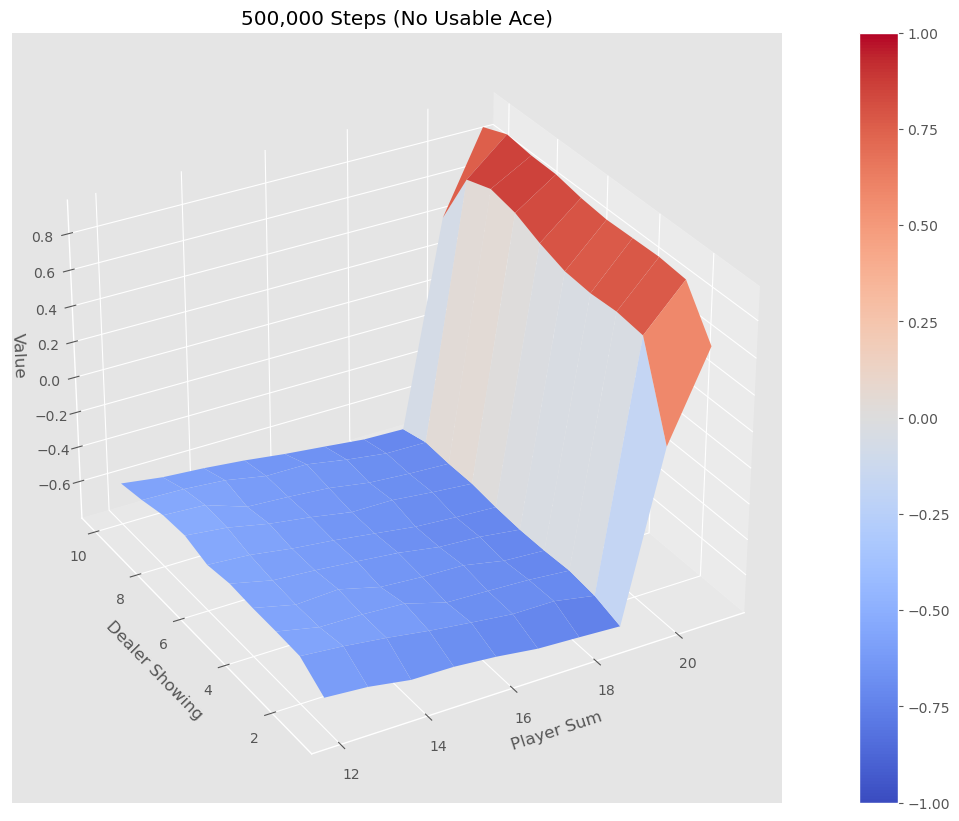

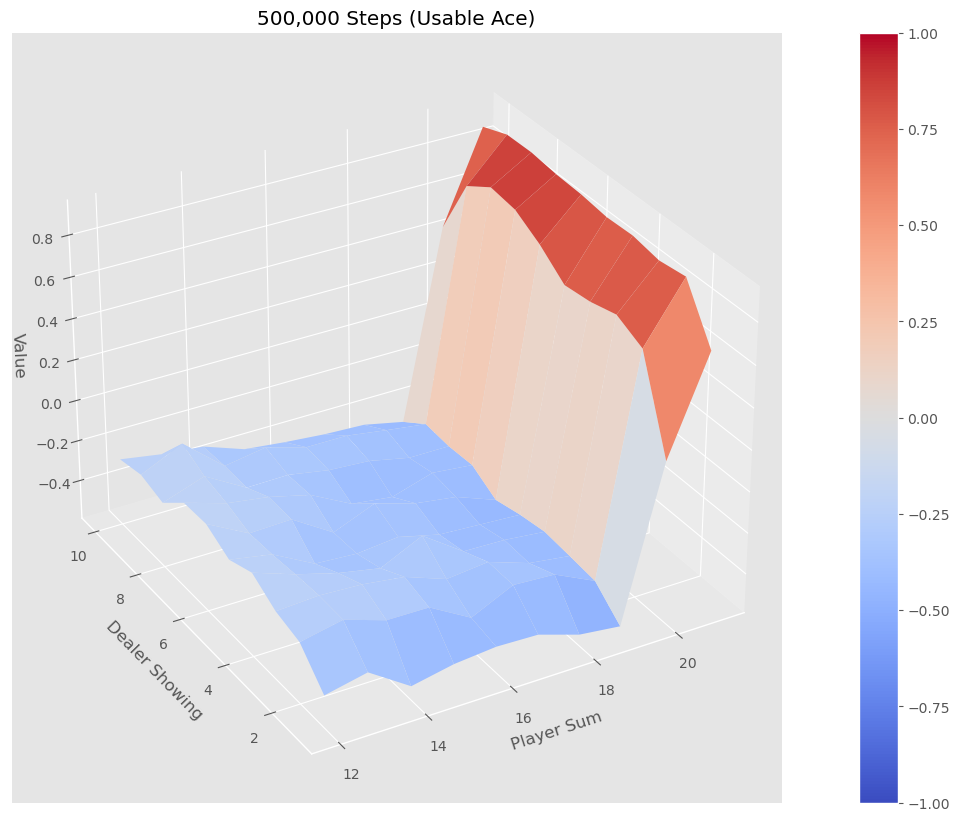

In [26]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")